# Change audio by detecting onset 
This notebook contains a method that could change the target video sound with a given audio.

### Load packages

In [28]:
import IPython
import os
import numpy as np
from moviepy.editor import *
import librosa
from IPython.display import Audio
from IPython.display import Video

In [29]:
# Read videos
origin_video_path = 'demo-data/original.mp4'
# conditional_video_path = 'demo-data/conditional.mp4'
conditional_video_path = 'demo-data/dog_bark.mp4'

ori_videoclip = VideoFileClip(origin_video_path)
con_videoclip = VideoFileClip(conditional_video_path)


In [30]:
Video(origin_video_path, width=640)

In [31]:
Video(conditional_video_path, width=640)

In [32]:
# get the audio track from video
ori_audioclip = ori_videoclip.audio
ori_audio, ori_sr = ori_audioclip.to_soundarray(), ori_audioclip.fps
con_audioclip = con_videoclip.audio
con_audio, con_sr = con_audioclip.to_soundarray(), con_audioclip.fps

ori_audio = ori_audio.mean(-1)
con_audio = con_audio.mean(-1)

target_sr = 22050
ori_audio = librosa.resample(ori_audio, orig_sr=ori_sr, target_sr=target_sr)
con_audio = librosa.resample(con_audio, orig_sr=con_sr, target_sr=target_sr)

ori_sr, con_sr = target_sr, target_sr

In [33]:
def detect_onset_of_audio(audio, sample_rate):
    onsets = librosa.onset.onset_detect(
        y=audio, sr=sample_rate, units='samples', delta=0.3)
    return onsets


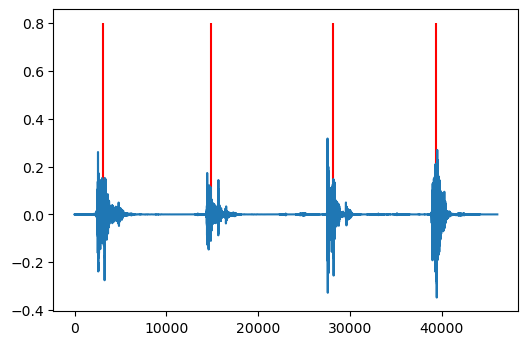

In [34]:
from matplotlib import pyplot as plt
onsets = detect_onset_of_audio(ori_audio, ori_sr)
plt.figure(dpi=100)

time = np.arange(ori_audio.shape[0])
plt.plot(time, ori_audio)
plt.vlines(onsets, 0, ymax=0.8, colors='r')
plt.show()


### Method
The baseline is quite simple, and it has several steps:
- Take the original video, and apply self-trained video onset detection model to detect the onset
- Detect onsets of conditional waveform (encoded and decoded by our codebook) and clip single onset event from them as sound candicates
- For each onset of original waveform, replace with conditional onset event randomly and then generate sound

In [35]:
%env CUDA_VISIBLE_DEVICES=9
import argparse
import numpy as np
import os
import sys
import time
from tqdm import tqdm
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


from config import init_args
import data
import models
from models import *
from utils import utils, torch_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


net = models.VideoOnsetNet(pretrained=False).to(device)
resume = 'checkpoints/EXP1/checkpoint_ep70.pth.tar'
net, _ = torch_utils.load_model(resume, net, device=device, strict=True)


env: CUDA_VISIBLE_DEVICES=9
=> loading checkpoint 'checkpoints/EXP1/checkpoint_ep70.pth.tar'
=> loaded checkpoint 'checkpoints/EXP1/checkpoint_ep70.pth.tar' (epoch 70)


In [36]:
import torchvision.transforms as transforms
from PIL import Image


vision_transform_list = [
    transforms.Resize((128, 128)),
    transforms.CenterCrop((112, 112)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
video_transform = transforms.Compose(vision_transform_list)

def read_image(frame_list):
    imgs = []
    convert_tensor = transforms.ToTensor()
    for img_path in frame_list:
        image = Image.open(img_path).convert('RGB')
        image = convert_tensor(image)
        imgs.append(image.unsqueeze(0))
    # (T, C, H ,W)
    imgs = torch.cat(imgs, dim=0).squeeze()
    imgs = video_transform(imgs)
    imgs = imgs.permute(1, 0, 2, 3)
    # (C, T, H ,W)
    return imgs


In [37]:
# process videos into frames and read them
import glob

save_path = 'demo-data/original_frames'
if os.path.exists(save_path):
    os.system(f'rm -rf {save_path}')
os.makedirs(save_path)
command = f'ffmpeg -v quiet -y -i \"{origin_video_path}\" -f image2 -vf \"scale=-1:360,fps=15\" -qscale:v 3 \"{save_path}\"/frame%06d.jpg'
os.system(command)

frame_list = glob.glob(f'{save_path}/*.jpg')
frame_list.sort()
frame_list = frame_list[:2 * 15]

frames = read_image(frame_list)


In [38]:
inputs = {
    'frames': frames.unsqueeze(0).to(device)
}
pred = net(inputs).squeeze()
pred = torch.sigmoid(pred).data.cpu().numpy()

In [39]:
def postprocess_video_onsets(probs, thres=0.5, nearest=5):
    # import pdb; pdb.set_trace()
    video_onsets = []
    pred = np.array(probs, copy=True)
    while True:
        max_ind = np.argmax(pred)
        video_onsets.append(max_ind)
        low = max(max_ind - nearest, 0)
        high = min(max_ind + nearest, pred.shape[0])
        pred[low: high] = 0
        if (pred > thres).sum() == 0:
            break
    video_onsets.sort()
    video_onsets = np.array(video_onsets)
    return video_onsets




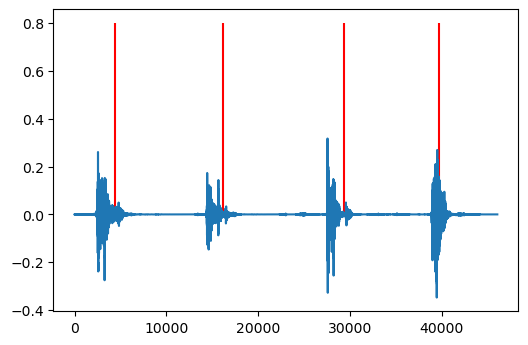

In [40]:
from matplotlib import pyplot as plt
# video_onsets = (np.nonzero(pred > 0.5)[0] / 15 * ori_sr).astype(int)
video_onsets = postprocess_video_onsets(pred, thres=0.5, nearest=4)
video_onsets = (video_onsets / 15 * ori_sr).astype(int)
plt.figure(dpi=100)

time = np.arange(ori_audio.shape[0])
plt.plot(time, ori_audio)
plt.vlines(video_onsets, 0, ymax=0.8, colors='r')
plt.show()


In [41]:
(onsets - video_onsets) / ori_sr
# video_onsets

array([-0.06068027, -0.0599093 , -0.05623583, -0.01206349])

In [42]:
def get_onset_audio_range(audio_len, onsets, i):
    if i == 0:
        prev_offset = int(onsets[i] // 3)
    else:
        prev_offset = int((onsets[i] - onsets[i - 1]) // 3)

    if i == onsets.shape[0] - 1:
        post_offset = int((audio_len - onsets[i]) // 4 * 2)
    else:
        post_offset = int((onsets[i + 1] - onsets[i]) // 4 * 2)
    return prev_offset, post_offset


In [43]:
# ori_onsets = detect_onset_of_audio(ori_audio, ori_sr)
con_onsets = detect_onset_of_audio(con_audio, con_sr)

np.random.seed(2022)
gen_audio = np.zeros_like(ori_audio)
for i in range(video_onsets.shape[0]):
    prev_offset, post_offset = get_onset_audio_range(int(con_sr * 2), video_onsets, i)
    j = np.random.choice(con_onsets.shape[0])
    prev_offset_con, post_offset_con = get_onset_audio_range(con_audio.shape[0], con_onsets, j)
    prev_offset = min(prev_offset, prev_offset_con)
    post_offset = min(post_offset, post_offset_con)
    gen_audio[video_onsets[i] - prev_offset: video_onsets[i] + post_offset] = con_audio[con_onsets[j] - prev_offset: con_onsets[j] + post_offset]



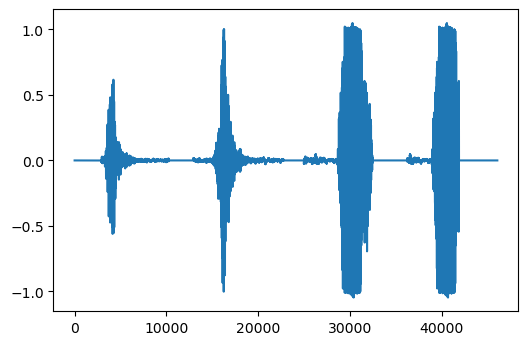

In [44]:
from matplotlib import pyplot as plt
plt.figure(dpi=100)
time = np.arange(gen_audio.shape[0])
plt.plot(time, gen_audio)
plt.show()


In [45]:
# save audio
import soundfile as sf
sf.write('data/gen_audio.wav', gen_audio, ori_sr)


In [46]:
gen_audioclip = AudioFileClip("data/gen_audio.wav")
gen_videoclip = ori_videoclip.set_audio(gen_audioclip)
gen_videoclip.write_videofile('data/generate.mp4')


t:  58%|█████▊    | 26/45 [00:41<00:05,  3.45it/s, now=None]

Moviepy - Building video data/generate.mp4.
MoviePy - Writing audio in generateTEMP_MPY_wvf_snd.mp3


t:  58%|█████▊    | 26/45 [00:42<00:05,  3.45it/s, now=None]

MoviePy - Done.
Moviepy - Writing video data/generate.mp4



t:  58%|█████▊    | 26/45 [01:03<00:05,  3.45it/s, now=None]

Moviepy - Done !
Moviepy - video ready data/generate.mp4


In [47]:
Video('data/generate.mp4', width=640)
